# **Credit Card Customer** : Clustering/Segmentation

By [Dito Wicaksana P.](https://github.com/ditoowp) | Data Resource: Google BigQuery

<center><img src="https://s28126.pcdn.co/blogs/ask-experian/wp-content/uploads/4-Types-of-Cards-Everyone-Should-Have-in-Their-Wallet-1400x933-1-900x600.jpg.optimal.jpg"/></center>

---

## **Introduction**

Dalam industri jasa keuangan yang kompetitif, memahami perilaku dan preferensi *customer* sangat penting untuk mengembangkan strategi pemasaran yang efektif, meningkatkan kepuasan *customer*, dan memperbaiki kinerja bisnis secara keseluruhan. Salah satu teknik yang ampuh untuk mencapai pemahaman ini adalah melalui segmentasi *customer*, yang melibatkan pembagian basis *customer* menjadi kelompok-kelompok yang berbeda dengan karakteristik dan perilaku serupa. Proyek ini berfokus pada segmentasi *customer* kartu kredit menggunakan teknik *unsupervised learning*, khususnya *clustering*.

## **Objective**

Objektif utama dari proyek segmentasi *customer* kartu kredit ini adalah untuk membagi *customer* kartu kredit menjadi beberapa segmen yang berbeda berdasarkan pola transaksi dan karakteristik mereka. Tujuan ini dipecah menjadi beberapa sub-objektif sebagai berikut:

1. **Mengidentifikasi segmen *customer* yang berbeda:**
    - Menggunakan teknik clustering untuk menemukan kelompok-kelompok *customer* yang memiliki perilaku dan karakteristik serupa.
    - Mengidentifikasi atribut-atribut utama yang membedakan satu segmen dari segmen lainnya.
2. **Memahami pola pengeluaran dan perilaku *customer*:**
    - Menganalisis pola transaksi dan kebiasaan pengeluaran setiap segmen untuk memahami perilaku belanja mereka.
    - Menggunakan wawasan ini untuk mengidentifikasi segmen *customer* dengan nilai tinggi dan segment yang mungkin berisiko tinggi.
3. **Meningkatkan strategi pemasaran dan penjualan:**
    - Mengembangkan strategi pemasaran yang lebih terarah dan efektif berdasarkan karakteristik dan kebutuhan spesifik dari setiap segmen.
    - Meningkatkan retensi *customer* dengan menawarkan promosi dan layanan yang sesuai dengan preferensi setiap segmen.
4. **Meningkatkan pengembangan produk dan layanan:**
    - Mengidentifikasi kebutuhan spesifik dari setiap segmen untuk mengembangkan produk dan layanan yang lebih sesuai.
    - Menciptakan produk dan layanan baru yang dapat menarik segmen *customer* yang berbeda dan meningkatkan kepuasan *customer* secara keseluruhan.
5. **Optimasi *risk management*:**
    - Mengidentifikasi segmen *customer* yang berisiko tinggi untuk mengimplementasikan strategi manajemen risiko yang lebih efektif.
    - Mengurangi potensi kerugian dengan mengawasi dan mengelola *customer* yang termasuk dalam segmen berisiko tinggi.

Dengan mencapai objektif-objektif ini, proyek ini diharapkan dapat memberikan wawasan yang mendalam dan actionable insights yang dapat membantu lembaga keuangan dalam pengambilan keputusan yang lebih baik dan perencanaan strategis yang lebih efektif.

## **Query SQL**

Pada proyek ini data diambil dari **Google BigQuery**, untuk itu perlu memperoleh terlebih dahulu data-nya.

**Note**: Query dilakukan di **Google Colab**.

In [1]:
# Fetching data from BigQuery
# dfquery = client.query('''
# SELECT *
# FROM `ftds-hacktiv8-project.phase1_ftds_031_rmt.credit-card-information`
# WHERE MOD(CUST_ID, 2) = 1 
# ''').to_dataframe() 

In [2]:
# # Convert dataset to csv
# dfquery.to_csv('credit_customer_information.csv')

## **Import Libraries**

In [3]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Training model
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.preprocessing import MinMaxScaler
from feature_engine.outliers import Winsorizer

# Saving model
import json
import pickle

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## **Data Loading**

In [4]:
# Defining dataframe
df = pd.read_csv('credit_customer_information.csv')

# Display data head
df.head()

,Unnamed: 0,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,0,3091,3.833185,0.125,45.00,45.00,0.0,0.0,0.125,0.125,0.0,0.0,0,1,500.0,0.000000,NaN,0.0,8
1,1,5069,0.000000,0.000,176.03,176.03,0.0,0.0,0.125,0.125,0.0,0.0,0,1,7000.0,0.000000,NaN,0.0,8
2,2,6075,757.964752,0.875,157.40,157.40,0.0,0.0,0.125,0.125,0.0,0.0,0,6,1200.0,1494.480376,2638.598410,0.0,8
3,3,6291,264.566591,0.375,1150.00,1150.00,0.0,0.0,0.125,0.125,0.0,0.0,0,1,1200.0,3029.380326,85.428885,0.0,8
4,4,7755,440.613643,1.000,600.00,600.00,0.0,0.0,0.125,0.125,0.0,0.0,0,1,1000.0,215.316424,137.846006,0.0,8


Terdapat feature `Unnamed: 0` yang menunjukkan value yang sama seperti *index*, maka dapat di-drop.

In [5]:
# Drop feature
df = df.drop(columns=['Unnamed: 0'])

In [6]:
# Display shape of the dataset
df.shape

(4475, 18)

In [7]:
# Display information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4475 entries, 0 to 4474
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           4475 non-null   int64  
 1   BALANCE                           4475 non-null   float64
 2   BALANCE_FREQUENCY                 4475 non-null   float64
 3   PURCHASES                         4475 non-null   float64
 4   ONEOFF_PURCHASES                  4475 non-null   float64
 5   INSTALLMENTS_PURCHASES            4475 non-null   float64
 6   CASH_ADVANCE                      4475 non-null   float64
 7   PURCHASES_FREQUENCY               4475 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        4475 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  4475 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            4475 non-null   float64
 11  CASH_ADVANCE_TRX                  4475 non-null   int64  
 12  PURCHA

Semua kolom merupakan numerikal dan terdapat *missing values* pada `MINIMUM_PAYMENTS`.

Dataset terdiri dari beberapa kolom, berikut adalah deskripsi dari masing-masing kolom:
* `CUST_ID`: Identifikasi pemegang kartu kredit
* `BALANCE`: Jumlah saldo yang tersisa di akun untuk melakukan pembelian
* `BALANCE_FREQUENCY`: Seberapa sering saldo diperbarui (1 = sering diperbarui, 0 = tidak sering diperbarui)
* `PURCHASES`: Jumlah pembelian yang dilakukan dari akun
* `ONEOFF_PURCHASES`: Jumlah maksimum pembelian yang dilakukan dalam satu transaksi
* `INSTALLMENTS_PURCHASES`: Jumlah pembelian yang dilakukan dengan cicilan
* `CASH_ADVANCE`: Uang tunai di muka yang diberikan kepada pengguna
* `PURCHASES_FREQUENCY`: Seberapa sering pembelian dilakukan (1 = sering melakukan pembelian, 0 = jarang melakukan pembelian)
* `ONEOFF_PURCHASES_FREQUENCY`: Seberapa sering pembelian dalam bentuk cicilan dilakukan (1 = sering dilakukan, 0 = jarang dilakukan)
* `CASH_ADVANCE_FREQUENCY`: Seberapa sering uang tunai di muka dibayarkan
* `CASH_ADVANCE_TRX`: Jumlah transaksi yang dilakukan dengan "Uang tunai di muka"
* `PURCHASES_TRX`: Jumlah transaksi pembelian yang dilakukan
* `CREDIT_LIMIT`: Batas kredit kartu untuk pengguna
* `PAYMENTS`: Jumlah pembayaran yang dilakukan oleh pengguna
* `MINIMUM_PAYMENTS`: Jumlah minimum pembayaran yang dilakukan oleh pengguna
* `PRC_FULL_PAYMENT`: Persentase pembayaran penuh yang dibayarkan oleh pengguna
* `TENURE`: Lama masa layanan kartu kredit untuk pengguna

Karena semua *feature* merupakan numerikal, jadi dapat langsung dicek **Stastistic Summary**-nya.

In [8]:
# Stats summary
df.describe()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4320.000000,4475.000000,4475.000000
mean,4475.000000,1563.205717,0.876933,1003.251343,596.369893,407.110215,984.288554,0.490579,0.202301,0.363886,0.136132,3.301229,14.929162,4494.878630,1740.075430,873.976757,0.150224,11.518212
std,2583.931114,2072.045789,0.238222,2060.034730,1653.425984,880.799744,2060.448056,0.402907,0.298203,0.397603,0.201036,7.134727,25.540814,3609.267706,2827.633858,2436.877272,0.289081,1.328925
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,2238.000000,124.432849,0.888889,39.560000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,376.913051,168.590144,0.000000,12.000000
50%,4475.000000,871.355430,1.000000,360.000000,45.650000,88.620000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,877.494612,313.980229,0.000000,12.000000
75%,6712.000000,2047.570799,1.000000,1102.420000,575.220000,455.885000,1138.887754,0.916667,0.250000,0.750000,0.250000,4.000000,17.000000,6500.000000,1911.596530,819.371080,0.125000,12.000000
max,8949.000000,18495.558550,1.000000,41050.400000,40624.060000,14686.100000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,347.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


Dapat dilihat pada `PURCHASES_FREQUENCY` nilai mean-nya adalah 0.49 yang artinya jumlah orang yang sering dan orang yang jarang membeli hampir tersebar merata pada data.

In [9]:
# Check for missing values
df.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          0
PAYMENTS                              0
MINIMUM_PAYMENTS                    155
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

Terdapat *missing values* pada `MINIMUM_PAYMENTS`, ini mungkin termasuk *missing values* tipe **Missing Completely at Random (MCAR)**. Diasumsikan *missing values* bisa terjadi karena kesalahan saat memasukkan data, misalnya petugas entri data tidak mengisi kolom tersebut secara tidak sengaja. *Handling* dapat dilakukan nanti setelah check nilai *skewness*-nya. Apabila terdapat *skewness* maka akan dilakukan imputasi menggunakan median.

In [10]:
# Check for duplicated data
df.duplicated().sum()

0

Tidak terdapat data yang terduplikasi.

## **Exploratory Data Analysis (EDA)**

Pada tahap ini akan lebih difokuskan ke beberapa *feature* yang dikira berdampak terhadap proses segmentasi, seperti: `BALANCE`, `PURCHASES`, `CASH ADVANCE`, dan `TENURE`.

In [11]:
# Set style and palette for visualization
sns.set(style="whitegrid")
palette = sns.color_palette("viridis", as_cmap=True)

### **Purchases**

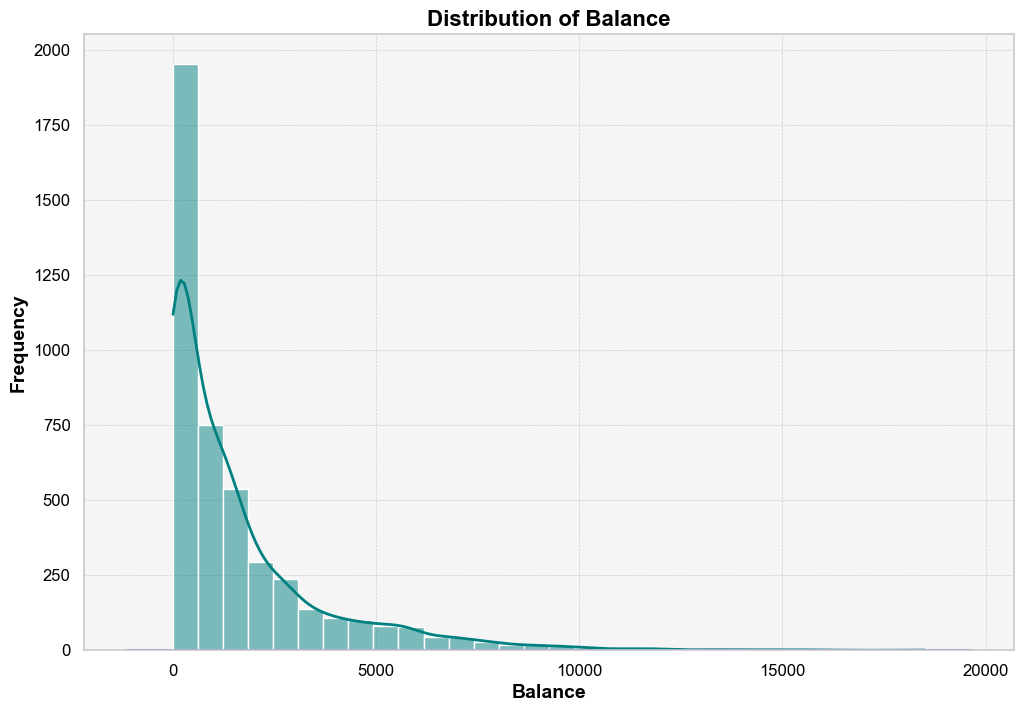

In [12]:
# Create the plot
plt.figure(figsize=(12, 8))
sns.histplot(df['BALANCE'], bins=30, kde=True, color='teal', line_kws={'linewidth': 2})
plt.title('Distribution of Balance', fontsize=16, fontweight='bold', color='black')
plt.xlabel('Balance', fontsize=14, fontweight='bold', color='black')
plt.ylabel('Frequency', fontsize=14, fontweight='bold', color='black')

# Customize grid and background
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().set_facecolor('whitesmoke')

# Customize KDE line
sns.kdeplot(df['BALANCE'], color='blue', linewidth=2)

# Customize the ticks and their labels
plt.xticks(fontsize=12, color='black')
plt.yticks(fontsize=12, color='black')

plt.show()

Ternyata lebih banyak *customer* yang memiliki *balance* yang sedikit dibandingkan dengan *customer* yang memiliki *balance* yang besar. Ini mungkin dikarenakan beberapa hal:
* Credit card baru dibuat dan customer masih belum  memindahkan uang ke dalam credit card-nya.
* Credit card digunakan hanya untuk transaksi kecil-kecilan. Contoh : Belanja di minimarket.

Selain itu, data juga menunjukkan **Positive Skewed**.

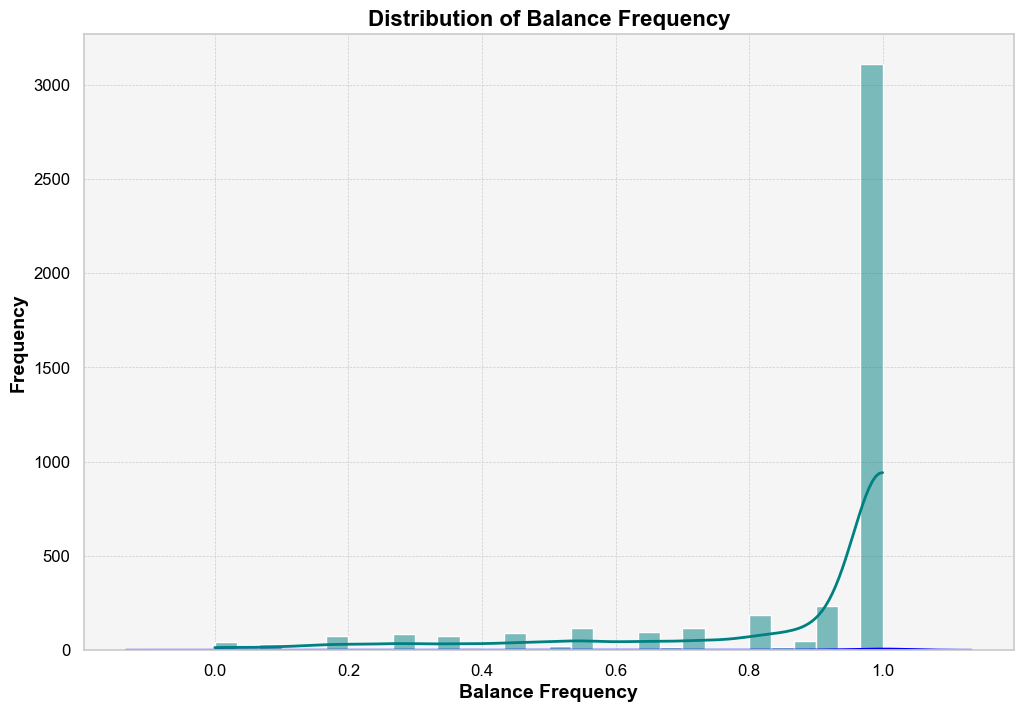

In [13]:
# Create the plot
plt.figure(figsize=(12, 8))
sns.histplot(df['BALANCE_FREQUENCY'], bins=30, kde=True, color='teal', line_kws={'linewidth': 2})
plt.title('Distribution of Balance Frequency', fontsize=16, fontweight='bold', color='black')
plt.xlabel('Balance Frequency', fontsize=14, fontweight='bold', color='black')
plt.ylabel('Frequency', fontsize=14, fontweight='bold', color='black')

# Customize grid and background
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().set_facecolor('whitesmoke')

# Customize KDE line
sns.kdeplot(df['BALANCE_FREQUENCY'], color='blue', linewidth=2)

# Customize the ticks and their labels
plt.xticks(fontsize=12, color='black')
plt.yticks(fontsize=12, color='black')

plt.show()

Lebih banyak *customer* yang sering update `BALANCE`-nya dibandingkan *customer* yang jarang update `BALANCE`-nya.

### **Purchases**

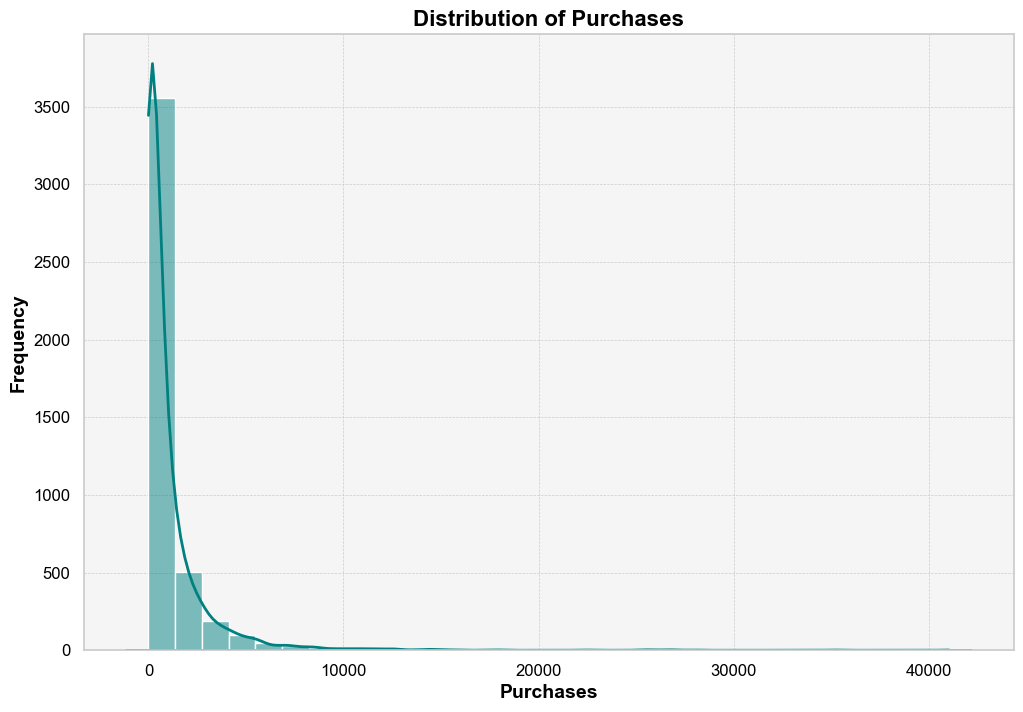

In [14]:
# Create the plot
plt.figure(figsize=(12, 8))
sns.histplot(df['PURCHASES'], bins=30, kde=True, color='teal', line_kws={'linewidth': 2})
plt.title('Distribution of Purchases', fontsize=16, fontweight='bold', color='black')
plt.xlabel('Purchases', fontsize=14, fontweight='bold', color='black')
plt.ylabel('Frequency', fontsize=14, fontweight='bold', color='black')

# Customize grid and background
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().set_facecolor('whitesmoke')

# Customize KDE line
sns.kdeplot(df['PURCHASES'], color='blue', linewidth=2)

# Customize the ticks and their labels
plt.xticks(fontsize=12, color='black')
plt.yticks(fontsize=12, color='black')

plt.show()

*Customer* cenderung melakukan pembelian dalam harga yang *moderate*. Namun ada beberapa *customer* yang melakukan pembelian dengan harga yang mahal (dilihat pada kanan histogram), ini mungkin merupakan **outliers**.

Data menunjukkan **Positive Skewed**.

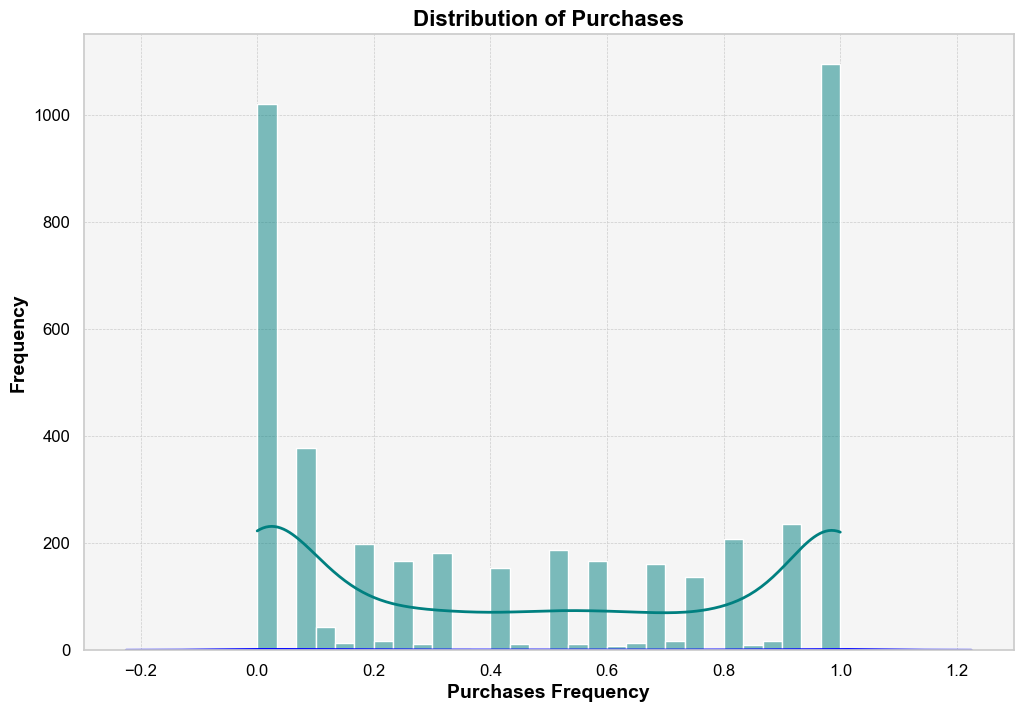

In [15]:
# Create the plot
plt.figure(figsize=(12, 8))
sns.histplot(df['PURCHASES_FREQUENCY'], bins=30, kde=True, color='teal', line_kws={'linewidth': 2})
plt.title('Distribution of Purchases', fontsize=16, fontweight='bold', color='black')
plt.xlabel('Purchases Frequency', fontsize=14, fontweight='bold', color='black')
plt.ylabel('Frequency', fontsize=14, fontweight='bold', color='black')

# Customize grid and background
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().set_facecolor('whitesmoke')

# Customize KDE line
sns.kdeplot(df['PURCHASES_FREQUENCY'], color='blue', linewidth=2)

# Customize the ticks and their labels
plt.xticks(fontsize=12, color='black')
plt.yticks(fontsize=12, color='black')

plt.show()

*Customer* yang sering melakukan pembelian dan yang jarang melakukan pembelian ternyata hampir sama, namun *customer* yang sering melakukan pembelian sedikit lebih banyak dibandingkan dengan *customer* yang jarang melakukan pembelian.

### **Cash Advance**

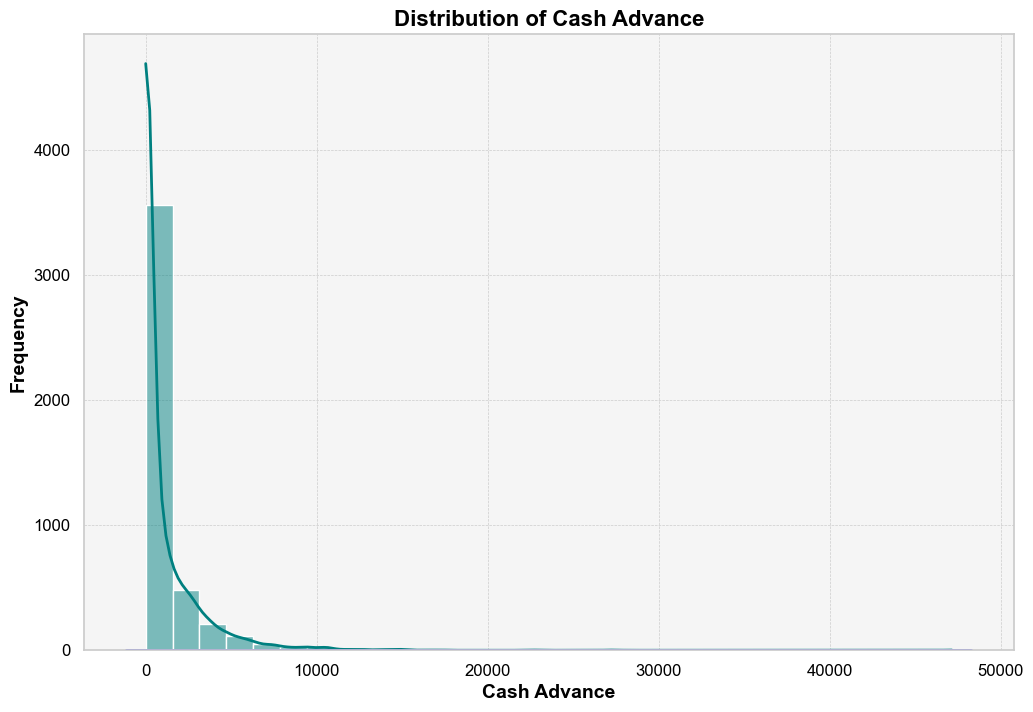

In [16]:
# Create the plot
plt.figure(figsize=(12, 8))
sns.histplot(df['CASH_ADVANCE'], bins=30, kde=True, color='teal', line_kws={'linewidth': 2})
plt.title('Distribution of Cash Advance', fontsize=16, fontweight='bold', color='black')
plt.xlabel('Cash Advance', fontsize=14, fontweight='bold', color='black')
plt.ylabel('Frequency', fontsize=14, fontweight='bold', color='black')

# Customize grid and background
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().set_facecolor('whitesmoke')

# Customize KDE line
sns.kdeplot(df['CASH_ADVANCE'], color='blue', linewidth=2)

# Customize the ticks and their labels
plt.xticks(fontsize=12, color='black')
plt.yticks(fontsize=12, color='black')

plt.show()

*Cash Advance* merupakan uang tunai yang dapat ditarik melalui mesin ATM oleh pengguna kartu kredit. Jadi kita menarik uang tunai yang sebenarnya bukan milik sendiri namun digunakan atas hasil penarikan kartu kredit di ATM. Namun, *Cash Advance* terdapat limit dalam penarikan uang tergantung limit kartu kredit yang dimiliki (*).

Dari definisi diatas dapat dipahami mengapa lebih banyak *customer* yang menarik tunai dengan jumlah yang sedikit, mungkin dikarenakan ada limit tersebut sehingga tidak dapat menarik tunai dengan jumlah yang lebih banyak lagi.

(*) Reference : [OCBC](https://www.ocbc.id/id/article/2022/02/10/cash-advance-adalah)

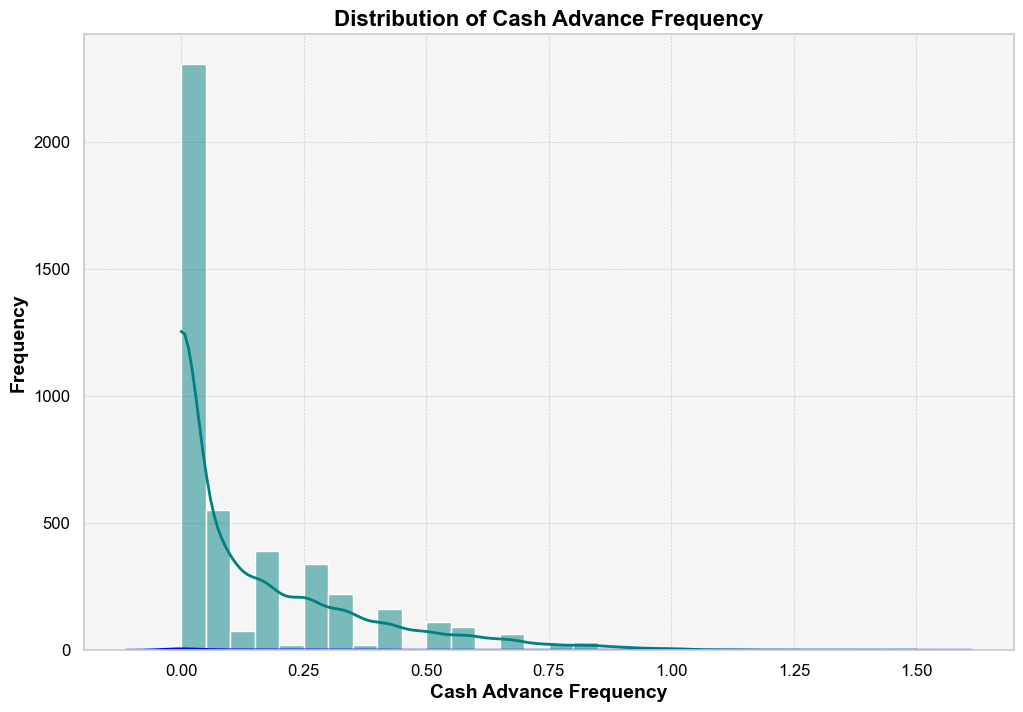

In [17]:
# Create the plot
plt.figure(figsize=(12, 8))
sns.histplot(df['CASH_ADVANCE_FREQUENCY'], bins=30, kde=True, color='teal', line_kws={'linewidth': 2})
plt.title('Distribution of Cash Advance Frequency', fontsize=16, fontweight='bold', color='black')
plt.xlabel('Cash Advance Frequency', fontsize=14, fontweight='bold', color='black')
plt.ylabel('Frequency', fontsize=14, fontweight='bold', color='black')

# Customize grid and background
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().set_facecolor('whitesmoke')

# Customize KDE line
sns.kdeplot(df['CASH_ADVANCE_FREQUENCY'], color='blue', linewidth=2)

# Customize the ticks and their labels
plt.xticks(fontsize=12, color='black')
plt.yticks(fontsize=12, color='black')

plt.show()

Sesuai dengan analisis diatas, bahwa *customer* lebih banyak yang tidak menggunakan *Cash Advance*. Namun dapat dilihat pada histogram *range* sumbu x mencapai 1.4, yang mana *range*-nya hanya 0 - 1.0 tandanya terdapat **outliers** pada *feature* ini.

### **Tenure**

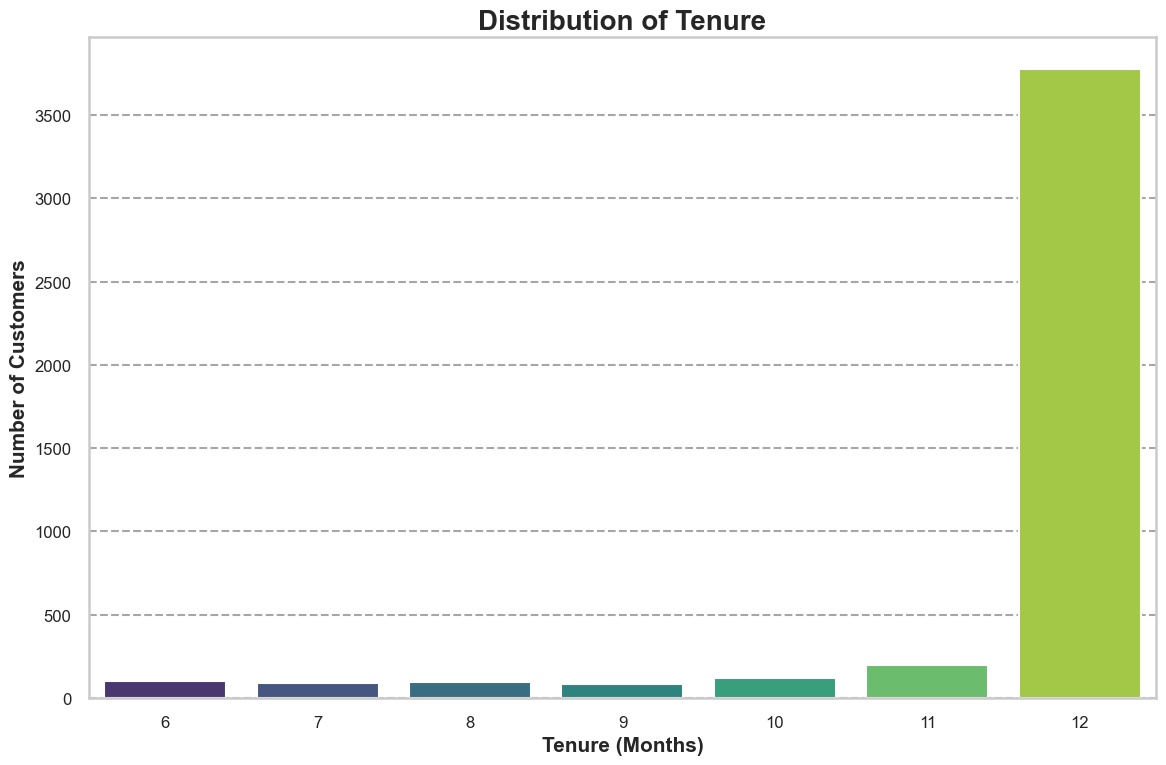

In [18]:
# Count plot tenure
sns.set(style='whitegrid', context='talk')
plt.figure(figsize=(12,8))
ax = sns.countplot(x='TENURE', data=df, palette='viridis')

# Create plot
ax.set_title('Distribution of Tenure', fontsize=20, weight='bold')
ax.set_xlabel('Tenure (Months)', fontsize=15, weight='bold')
ax.set_ylabel('Number of Customers', fontsize=15, weight='bold')
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.yaxis.grid(True, linestyle='--', which='major', color='gray', alpha=0.7)
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

Kebanyakan *customer* memiliki masa aktif-nya selama 12 bulan.

### **Correlation Matrix**

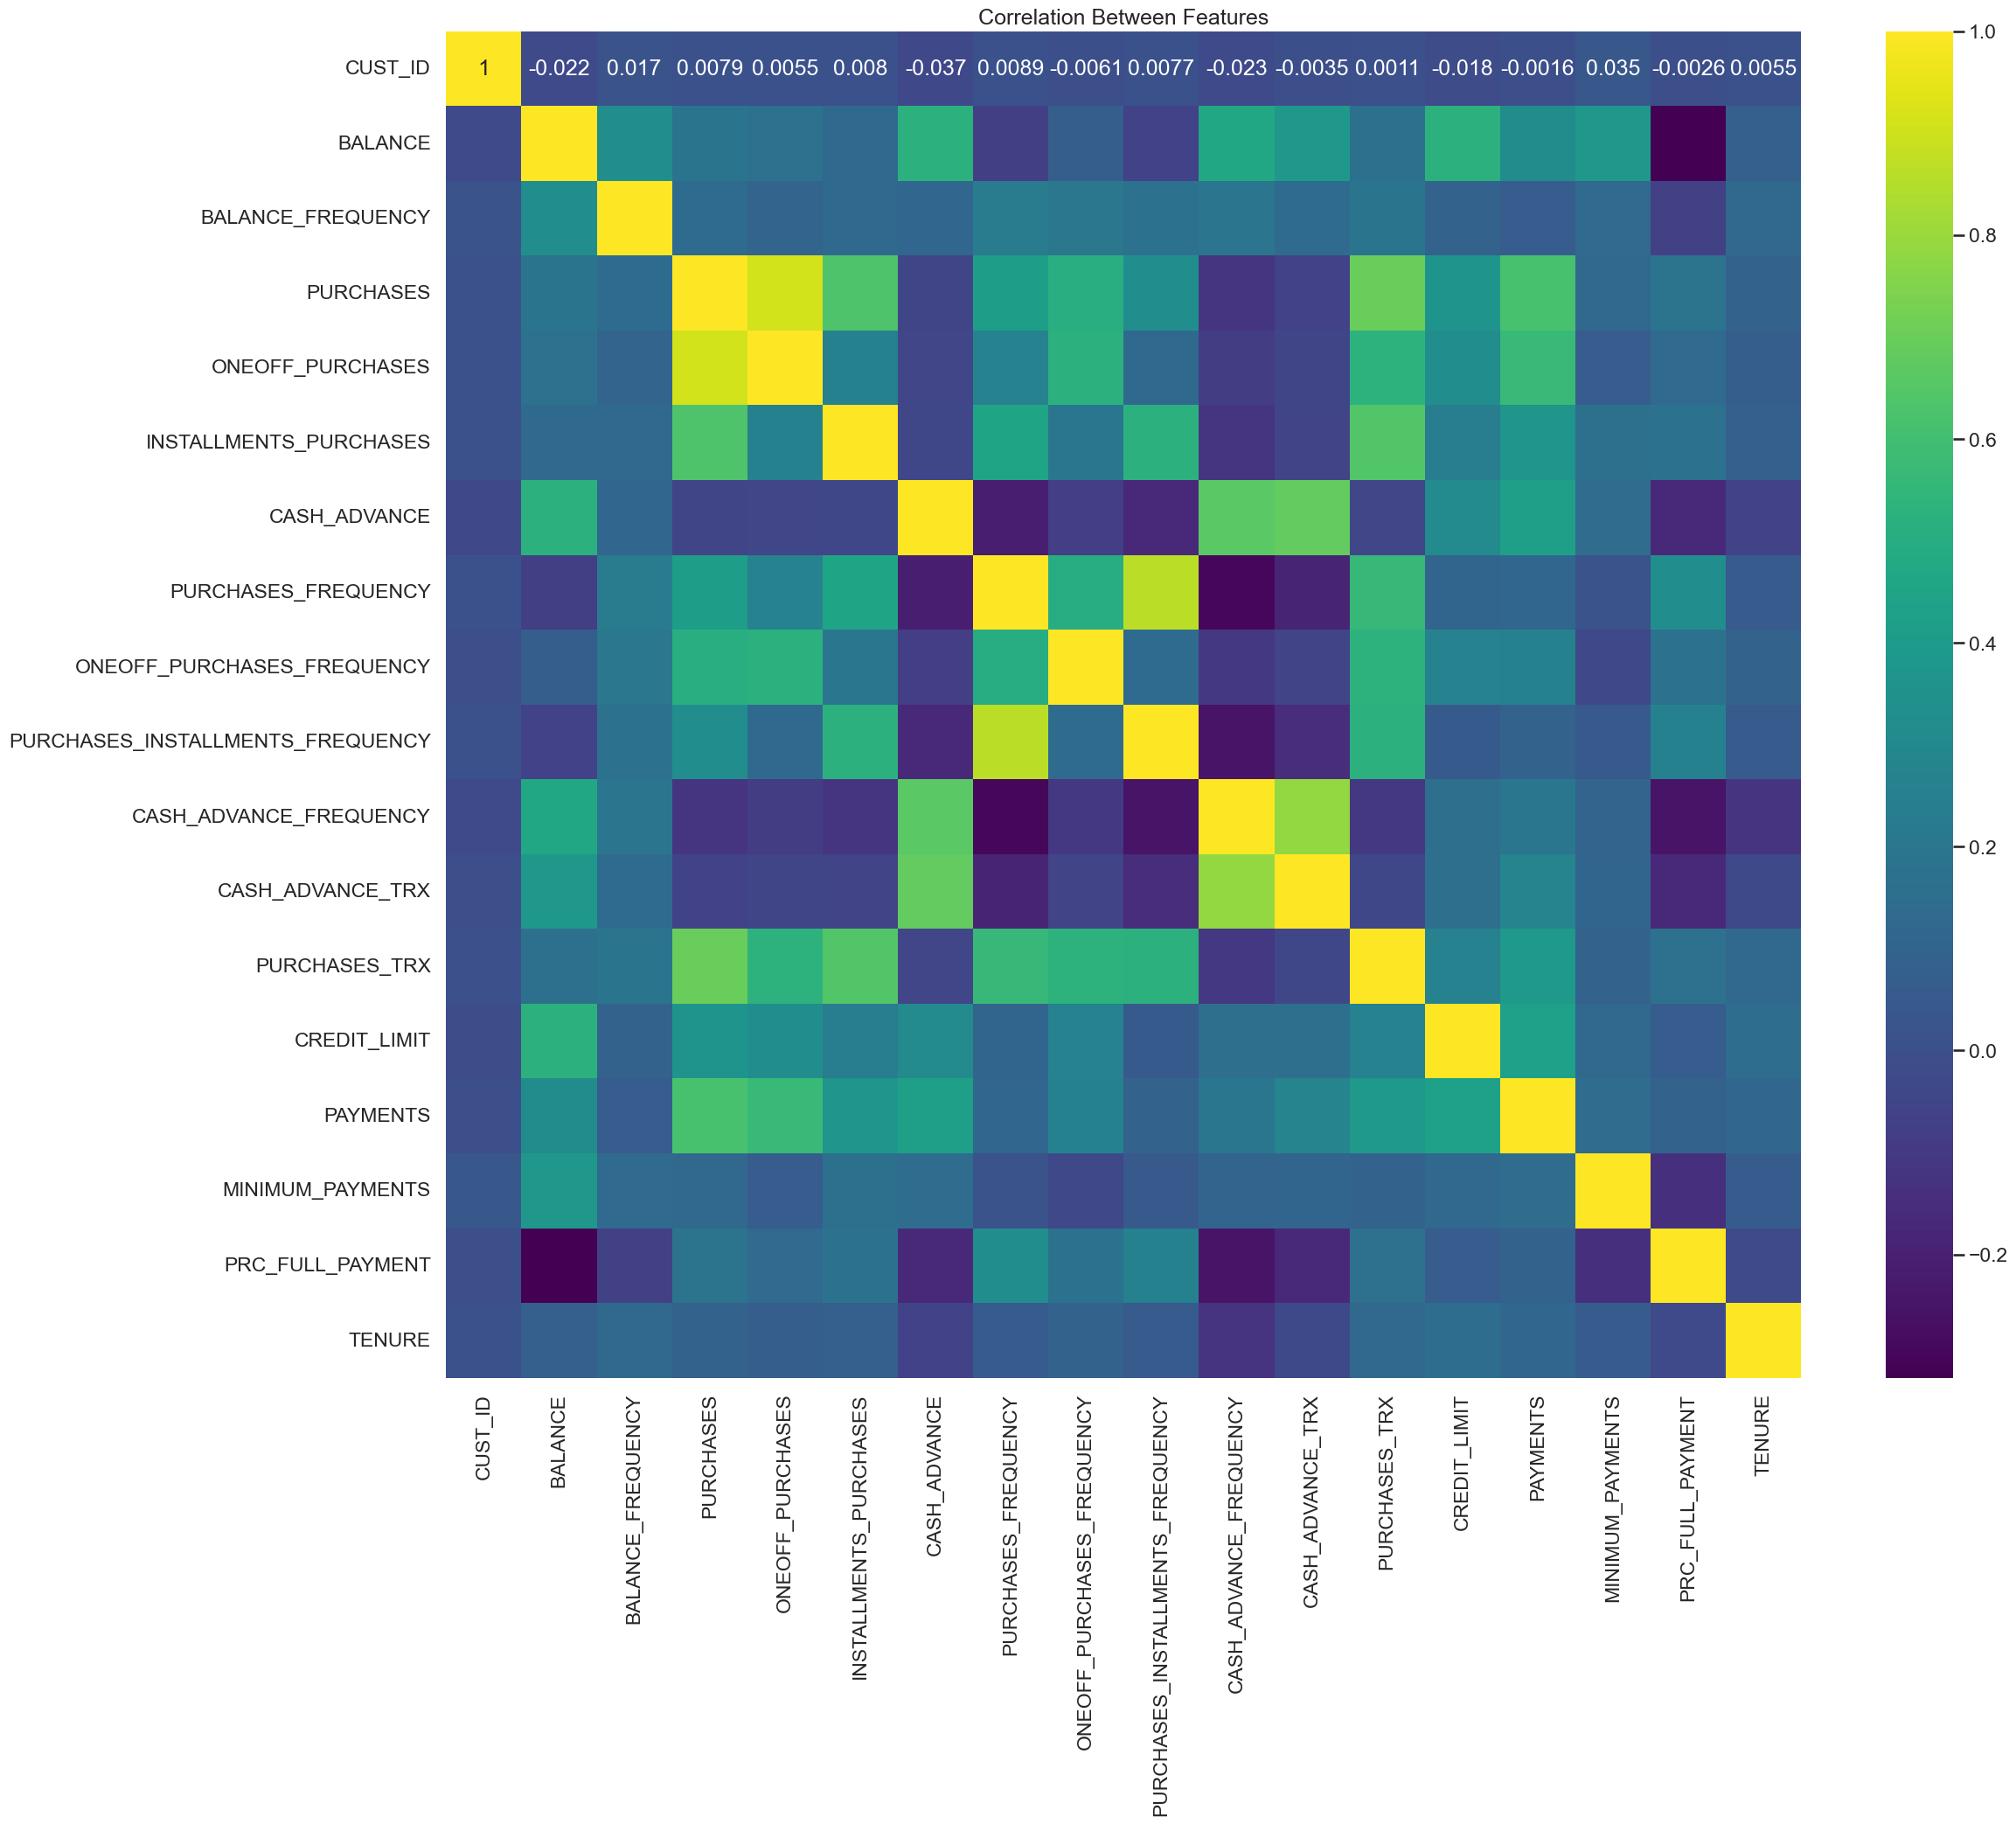

In [19]:
# Create plot
plt.figure(figsize=(25,20))
sns.heatmap(df.corr(), annot=True, cmap='viridis')
plt.title('Correlation Between Features')
plt.show()

`CUST_ID` dan `TENURE` tidak memiliki korelasi terhadap *feature* lainnya. `CUST_ID` tidak memiliki korelasi dikarenakan hanya bentuk identifikasi pengguna kartu kredit. Sedangkan `TENURE` hanya masa aktif/jangka waktu penggunaan kartu kredit, sehingga tidak terlalu berhubungan dengan *feature* lainnya.

## **Feature Engineering**

### **Handling Missing Values**

In [20]:
# Display missing values
df.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          0
PAYMENTS                              0
MINIMUM_PAYMENTS                    155
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

Sebelumnya pada **Data Loading** sudah diketahui terdapat *missing values* pada `MINIMUM_PAYMENTS`. Pada tahap ini baru di-*handling*. Untuk *handling* sendiri perlu mengetahui apakah terdapat *skewness* atau tidak pada *feature*.

In [21]:
# Display skewness feature minimum payments
skew_min_pay = df['MINIMUM_PAYMENTS'].skew()
print(f'Skewness for MINIMUM_PAYMENTS: {skew_min_pay}')

Skewness for MINIMUM_PAYMENTS: 14.669771084332645


Terdapat *skewness* pada `MINIMUM_PAYMENTS`, sehingga bisa dilakukan handling dengan imputasi menggunakan median.

In [22]:
# Handling missing values
df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].median(), inplace=True)

In [23]:
# Display missing values setelah di-handling
df.isnull().sum()

CUST_ID                             0
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

*Missing values* sudah tidak ada lagi pada `MINIMUM_PAYMENTS`.

### **Handling Outliers**

In [24]:
# Display persentase outliers
for k, v in df.items():
  q1 = v.quantile(0.25) ## IQR digunakan karena diasumsikan semua data bukan gaussian/tidak normal
  q3 = v.quantile(0.75)
  iqr = q3 - q1
  v_col = v[(v <= q1 - 1.5 * iqr) | (v >= q3 + 1.5 * iqr)]
  perc = np.shape(v_col)[0] * 100.0 / np.shape(df)[0]
  print("Column %s outliers = %.2f%%" % (k, perc))

Column CUST_ID outliers = 0.00%
Column BALANCE outliers = 8.02%
Column BALANCE_FREQUENCY outliers = 16.72%
Column PURCHASES outliers = 9.47%
Column ONEOFF_PURCHASES outliers = 11.69%
Column INSTALLMENTS_PURCHASES outliers = 9.88%
Column CASH_ADVANCE outliers = 11.26%
Column PURCHASES_FREQUENCY outliers = 0.00%
Column ONEOFF_PURCHASES_FREQUENCY outliers = 12.47%
Column PURCHASES_INSTALLMENTS_FREQUENCY outliers = 0.00%
Column CASH_ADVANCE_FREQUENCY outliers = 3.91%
Column CASH_ADVANCE_TRX outliers = 10.77%
Column PURCHASES_TRX outliers = 9.16%
Column CREDIT_LIMIT outliers = 2.68%
Column PAYMENTS outliers = 9.25%
Column MINIMUM_PAYMENTS outliers = 10.70%
Column PRC_FULL_PAYMENT outliers = 17.81%
Column TENURE outliers = 100.00%


Hampir semua *feature* kecuali `PURCHASES_FREQUENCY` dan `PURCHASES_INSTALLMENTS_FREQUENCY` terdapat *outliers*. Namun, disini diputuskan untuk membiarkan *outliers* karena merupakan data dari pengguna kartu kredit, sehingga diasumsikan bahwa *outliers* merupakan *outliers* yang natural.

### **Feature Selection**

Sebelumnya pada EDA, *heatmap correlation* menunjukkan *feature* `CUST_ID` dan `TENURE` tidak memiliki korelasi antar *feature* lainnya. Tapi, disini diputuskan hanya untuk men-drop `CUST_ID` yang mana hanya nomor identitas pengguna kartu kredit.

In [25]:
# Dropping features
df = df.drop(columns=['CUST_ID'])
df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,3.833185,0.125,45.00,45.00,0.0,0.0,0.125,0.125,0.0,0.0,0,1,500.0,0.000000,313.980229,0.0,8
1,0.000000,0.000,176.03,176.03,0.0,0.0,0.125,0.125,0.0,0.0,0,1,7000.0,0.000000,313.980229,0.0,8
2,757.964752,0.875,157.40,157.40,0.0,0.0,0.125,0.125,0.0,0.0,0,6,1200.0,1494.480376,2638.598410,0.0,8
3,264.566591,0.375,1150.00,1150.00,0.0,0.0,0.125,0.125,0.0,0.0,0,1,1200.0,3029.380326,85.428885,0.0,8
4,440.613643,1.000,600.00,600.00,0.0,0.0,0.125,0.125,0.0,0.0,0,1,1000.0,215.316424,137.846006,0.0,8


### **Feature Scaling**

In [26]:
# Scaling using MinMax
scaler = MinMaxScaler()
scaler.fit(df)

df_scaled = scaler.transform(df)
df_scaled

array([[2.07248945e-04, 1.25000000e-01, 1.09621344e-03, ...,
        4.10910520e-03, 0.00000000e+00, 3.33333333e-01],
       [0.00000000e+00, 0.00000000e+00, 4.28814336e-03, ...,
        4.10910520e-03, 0.00000000e+00, 3.33333333e-01],
       [4.09809063e-02, 8.75000000e-01, 3.83431099e-03, ...,
        3.45335804e-02, 0.00000000e+00, 3.33333333e-01],
       ...,
       [7.15208780e-02, 1.00000000e+00, 0.00000000e+00, ...,
        4.09412344e-03, 0.00000000e+00, 8.33333333e-01],
       [5.73322114e-02, 1.00000000e+00, 0.00000000e+00, ...,
        3.62621901e-03, 0.00000000e+00, 8.33333333e-01],
       [1.86405521e-01, 1.00000000e+00, 4.99386120e-03, ...,
        1.07036552e-02, 0.00000000e+00, 8.33333333e-01]])

### **Explained Variance Ration (EVR)**

In [27]:
# Display shape of the data before PCA
df_scaled.shape

(4475, 17)

In [28]:
# Define PCA
pca = PCA()
pca.fit(df_scaled)

PCA()

In [29]:
# Check components for retaining 95% information
cumsum = np.cumsum(pca.explained_variance_ratio_)
features = np.argmax(cumsum >= 0.95) + 1
print('Number of features with 95% retained information : ', features)

Number of features with 95% retained information :  7


Dari sini dapat kita ketahui bahwa untuk mempertahankan 95% informasi data, kita hanya membutuhkan 7 *feature*. Selanjutnya kita check dengan melakukan visualiasi untuk mengkonfirmasi lagi.

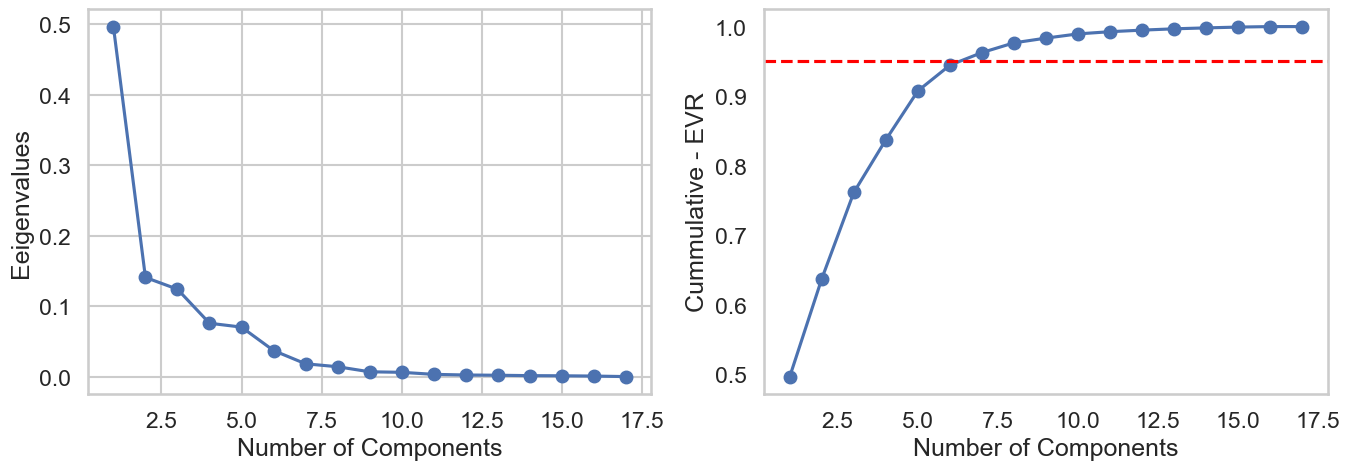

In [30]:
# Plotting
fig,ax=plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,18),pca.explained_variance_ratio_, marker='o')
ax[0].set_xlabel('Number of Components')
ax[0].set_ylabel('Eeigenvalues')

ax[1].plot(range(1,18),np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.axhline(y=0.95, color='red', linestyle='--')
ax[1].set_xlabel('Number of Components')
ax[1].set_ylabel('Cummulative - EVR')
plt.grid()
plt.show()

Dari visualisasi *Cummulative - EVR* bahwa dengan menggunakan 7 komponen saja kita dapat mempertahankan 95% informasi dari data, sesuai pada informasi sebelum visualisasi.

### **Principal Component Analysis (PCA)**

In [31]:
# Reduction
pca7 = PCA(n_components=7) ## parameter n_components didapatkan dari tahap EVR
pca7.fit(df_scaled)

df_scaled_pca = pca7.transform(df_scaled)

In [32]:
# Convert into dataframe
df_pca = pd.DataFrame(df_scaled_pca, columns=['PCA_'+ str(i) for i in range(1,8)])
df.tail(10)

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
4465,4438.521324,1.000000,591.84,109.16,482.68,564.365429,0.636364,0.181818,0.454545,0.272727,3,11,17000.0,5552.601399,1094.486286,0.00,11
4466,1135.703750,1.000000,92.07,0.00,92.07,81.509491,0.272727,0.000000,0.181818,0.272727,3,3,1200.0,355.798199,434.689529,0.00,11
4467,185.984965,0.454545,482.24,392.24,90.00,903.843591,0.272727,0.181818,0.090909,0.272727,8,8,1200.0,2333.997439,160.900585,0.25,11
4468,3531.167073,0.900000,797.50,577.83,219.67,5273.226918,0.700000,0.400000,0.500000,0.900000,33,21,4000.0,2979.546700,3052.080103,0.00,10
4469,1917.895730,1.000000,285.07,285.07,0.00,6084.858872,0.363636,0.363636,0.000000,1.090909,28,6,3000.0,5692.682993,556.449635,0.00,11
4470,9629.808851,1.000000,0.00,0.00,0.00,4372.393835,0.000000,0.000000,0.000000,0.545455,9,0,12000.0,2468.988022,2134.295731,0.00,11
4471,1040.030221,1.000000,0.00,0.00,0.00,1390.648290,0.000000,0.000000,0.000000,0.545455,18,0,1400.0,290.129620,287.994171,0.00,11
4472,1322.818587,1.000000,0.00,0.00,0.00,762.301096,0.000000,0.000000,0.000000,0.545455,11,0,1500.0,1035.627320,312.835530,0.00,11
4473,1060.391273,1.000000,0.00,0.00,0.00,1475.858013,0.000000,0.000000,0.000000,0.545455,10,0,2000.0,407.360560,277.084736,0.00,11
4474,3447.674222,1.000000,205.00,205.00,0.00,4548.057776,0.090909,0.090909,0.000000,0.545455,7,1,10500.0,665.239171,817.844662,0.00,11


## **Model Definition**

Dikarenakan dataset merupakan data numerikal semua dan diasumsikan *outliers* merupakan data penting sehingga tidak dilakukan handling, maka model yang dipilih adalah **K-Means**.

Sebelum menggunakan **K-Means**, perlu mengetahui jumlah *cluster* yang sesuai. Untuk itu akan dilakukan evaluasi menggunakan **Elbow Method** terlebih dahulu yang nanti akan diikuti dengan **Silhoutte Score** untuk mengkonfirmasi lagi apakah jumlah *cluster* sudah sesuai atau belum.

### **Elbow Method**

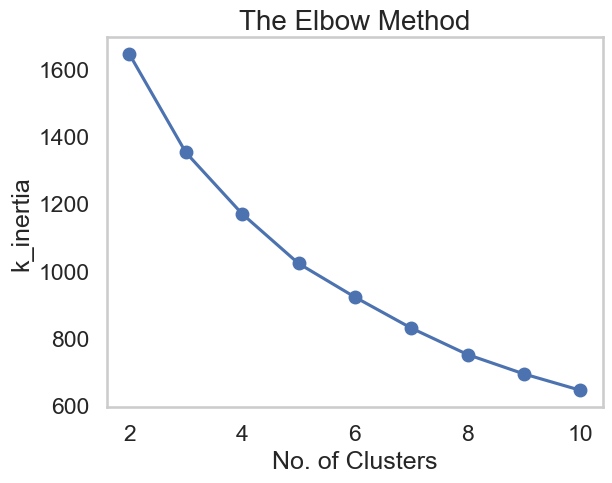

In [33]:
# Define k_inertia
k_inertia = []


for i in range(2, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 3)
    km.fit(df_pca)
    k_inertia.append(km.inertia_)

# Plotting elbow method
plt.plot(range(2, 11), k_inertia, marker ="o")
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('k_inertia')
plt.grid()
plt.show()

Walaupun tidak terlalu terlihat siku atau *elbow*-nya, disini diambil ***cluster* 4** karena penurunan inersia-nya tidak terlalu signifikan setelah *cluster* 4.

### **Silhoutte Score**

In [34]:
def plot_silhouette(range_n_clusters, X, random_state):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 4)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters = n_clusters, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_state)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_

        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

For n_clusters = 2 The average silhouette_score is : 0.40186024975747564
For n_clusters = 3 The average silhouette_score is : 0.3877566221893245
For n_clusters = 4 The average silhouette_score is : 0.3337396803958813
For n_clusters = 5 The average silhouette_score is : 0.33413134693120083
For n_clusters = 6 The average silhouette_score is : 0.31337326183328157
For n_clusters = 7 The average silhouette_score is : 0.33051084393199254


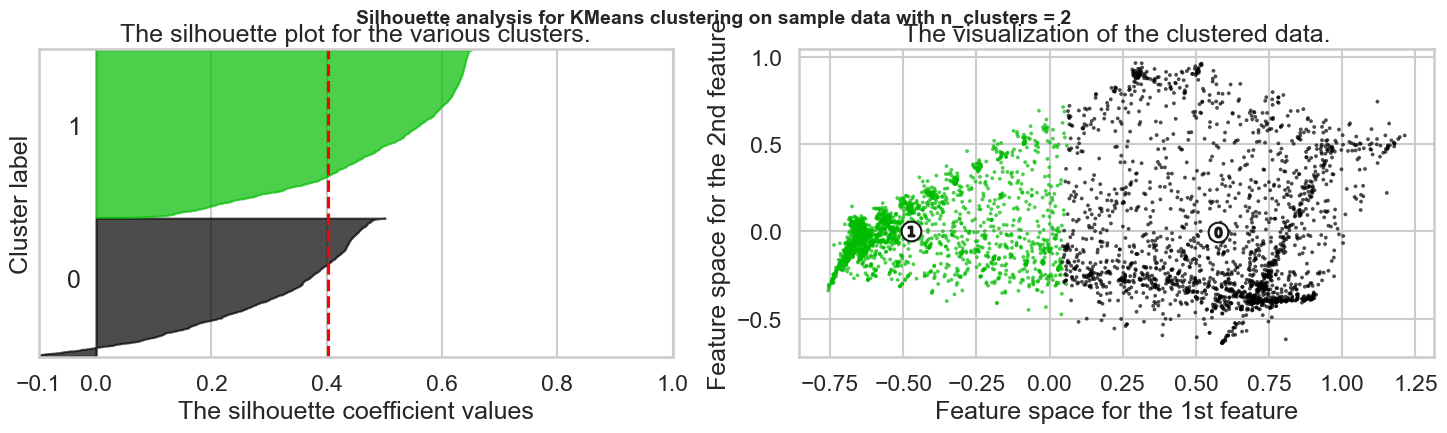

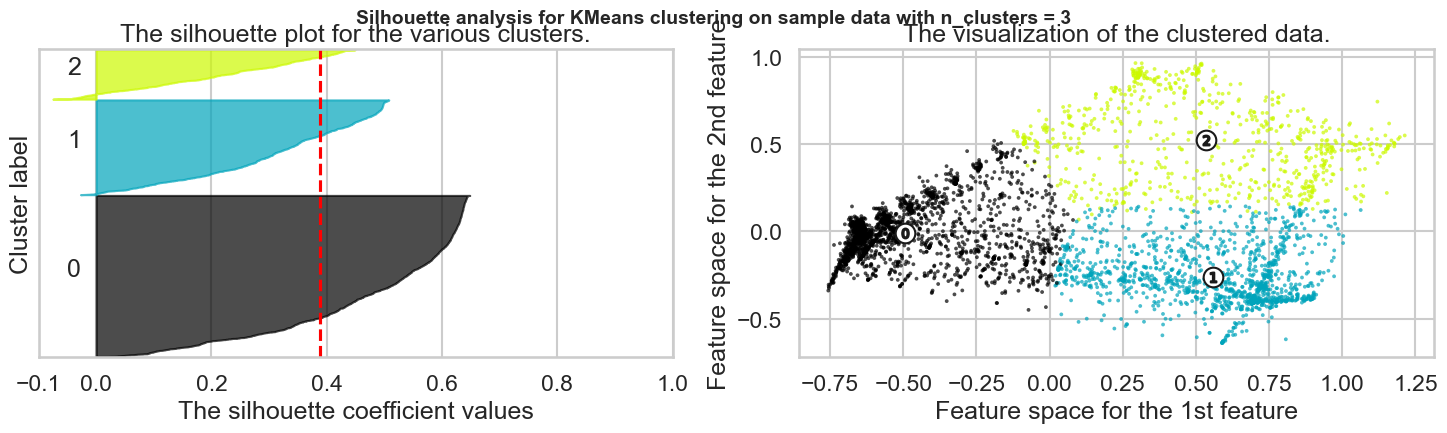

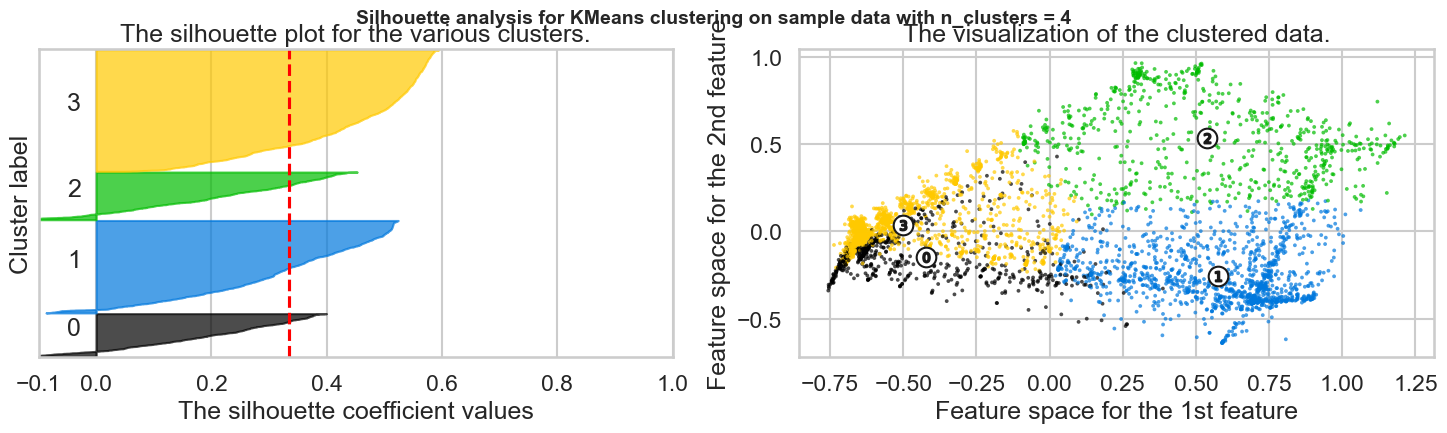

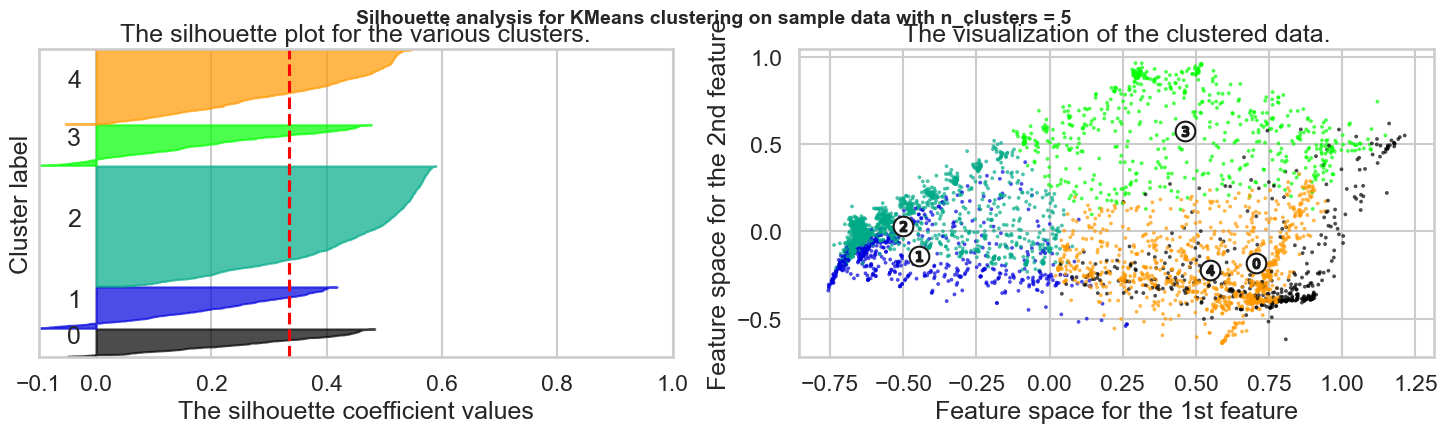

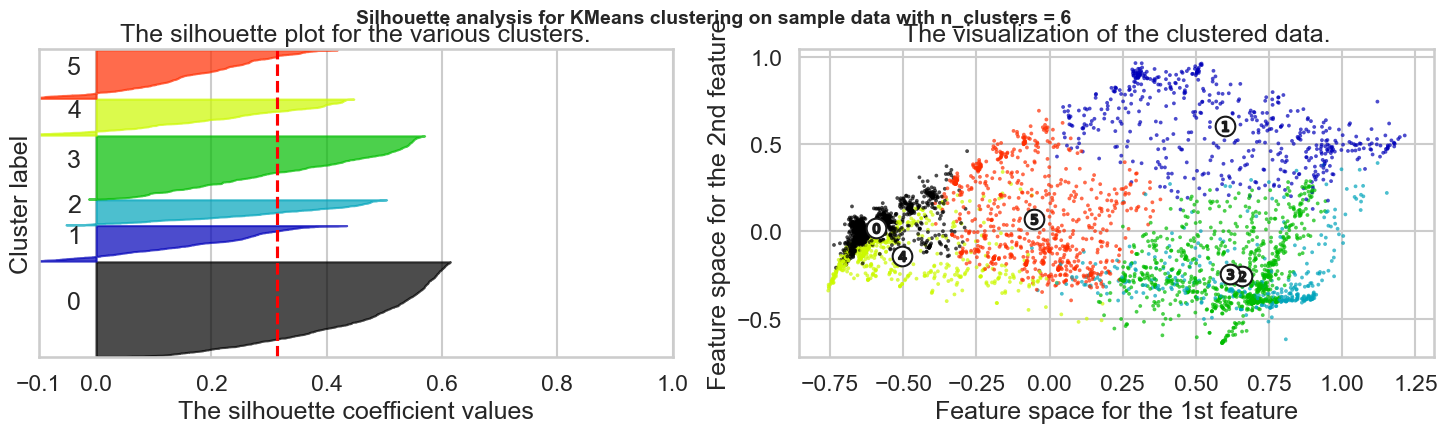

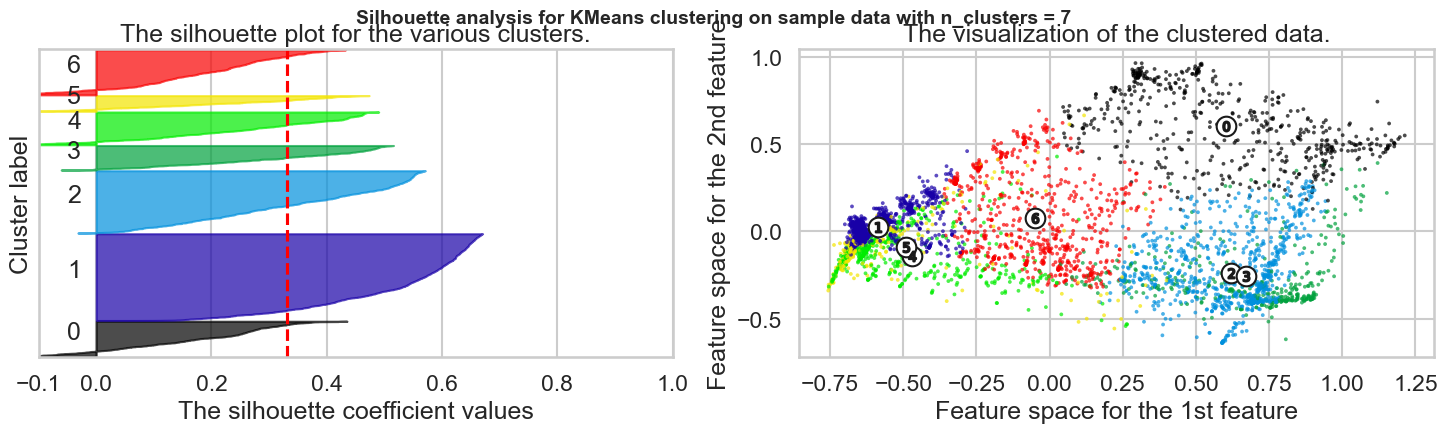

In [35]:
plot_silhouette(range(2, 8), df_scaled_pca, 3)

Ternyata dari **Silhoutte Score** jumlah *cluster* yang paling baik adalah 3. Jumlah *cluster* tersebut dipilih karena berdasarkan visualisasi, tidak ada data yang tertimpa/*overlap*. Dari kedua metode evaluasi ini kita akan menggunakan **Silhouette Score** dengan jumlah *cluster* 3.

## **Model Training**

In [36]:
# Train model
km = KMeans(n_clusters = 3,init = 'k-means++', max_iter = 300, n_init = 10, random_state = 3)
km.fit(df_pca)

KMeans(n_clusters=3, n_init=10, random_state=3)

## **Model Evaluation**

Untuk evaluasi kita akan menggunakan visualisasi **2Dimensional**.

### **2Dimensional K-Means**

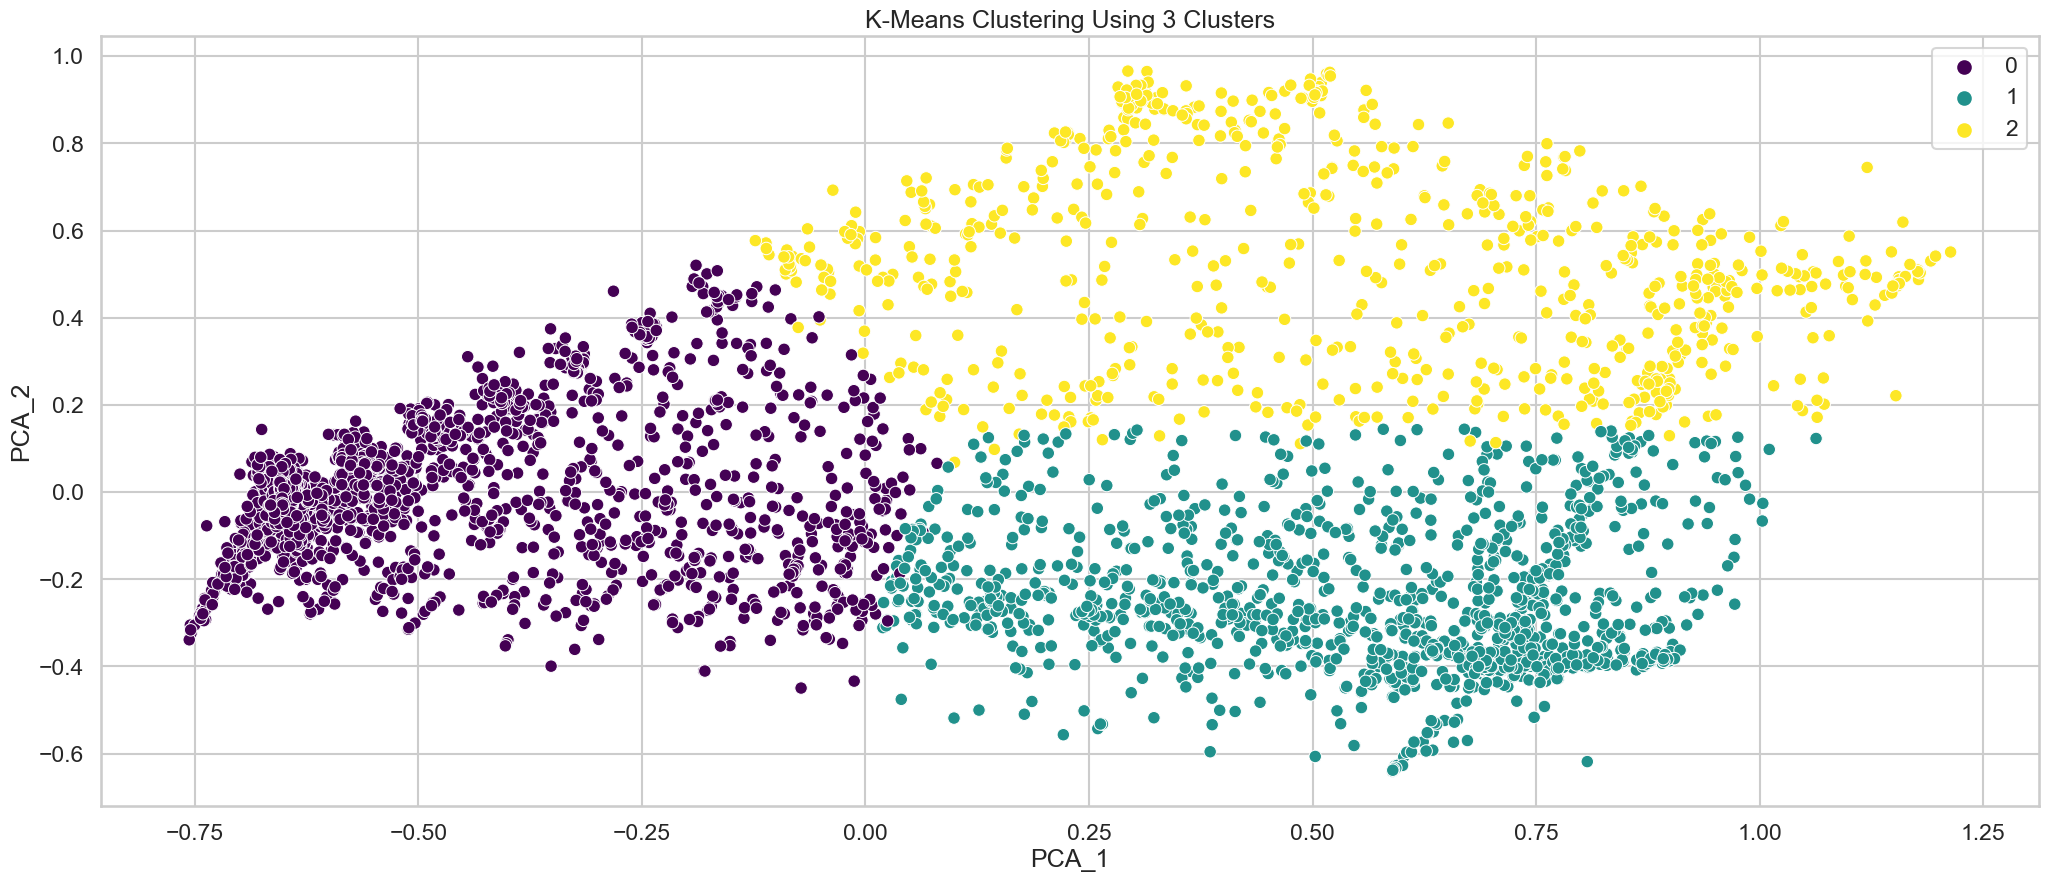

In [37]:
# Display 2 dimensional menggunakan scatterplot
plt.figure(figsize=(25, 10))
sns.scatterplot(x='PCA_1', y='PCA_2', hue=km.labels_, data=df_pca, palette='viridis')
plt.title('K-Means Clustering Using 3 Clusters')
plt.show()

Dapat dilihat bahwa pembagian data terlihat baik, tidak ada yang tertimpa/*overlap*.

### **EDA After Clustering**

In [38]:
# Define for prediction
pred = km.predict(df_pca)
pred

array([0, 0, 0, ..., 0, 0, 0])

In [39]:
# Insert output into dataframe
df_km = df
df_km['CLUSTER'] = pred
df_km


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,CLUSTER
0,3.833185,0.125,45.00,45.00,0.0,0.000000,0.125000,0.125000,0.0,0.000000,0,1,500.0,0.000000,313.980229,0.0,8,0
1,0.000000,0.000,176.03,176.03,0.0,0.000000,0.125000,0.125000,0.0,0.000000,0,1,7000.0,0.000000,313.980229,0.0,8,0
2,757.964752,0.875,157.40,157.40,0.0,0.000000,0.125000,0.125000,0.0,0.000000,0,6,1200.0,1494.480376,2638.598410,0.0,8,0
3,264.566591,0.375,1150.00,1150.00,0.0,0.000000,0.125000,0.125000,0.0,0.000000,0,1,1200.0,3029.380326,85.428885,0.0,8,0
4,440.613643,1.000,600.00,600.00,0.0,0.000000,0.125000,0.125000,0.0,0.000000,0,1,1000.0,215.316424,137.846006,0.0,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4470,9629.808851,1.000,0.00,0.00,0.0,4372.393835,0.000000,0.000000,0.0,0.545455,9,0,12000.0,2468.988022,2134.295731,0.0,11,0
4471,1040.030221,1.000,0.00,0.00,0.0,1390.648290,0.000000,0.000000,0.0,0.545455,18,0,1400.0,290.129620,287.994171,0.0,11,0
4472,1322.818587,1.000,0.00,0.00,0.0,762.301096,0.000000,0.000000,0.0,0.545455,11,0,1500.0,1035.627320,312.835530,0.0,11,0
4473,1060.391273,1.000,0.00,0.00,0.0,1475.858013,0.000000,0.000000,0.0,0.545455,10,0,2000.0,407.360560,277.084736,0.0,11,0


In [40]:
# Check cluster value counts
df_km['CLUSTER'].value_counts()

CLUSTER
0    2361
1    1390
2     724
Name: count, dtype: int64

In [41]:
# Summary statistic balance
summ_cluster_balance = df_km.groupby('CLUSTER').agg({
    'BALANCE': ['mean', 'median', 'std']}).reset_index()

summ_cluster_balance_freq = df_km.groupby('CLUSTER').agg({
    'BALANCE_FREQUENCY': ['mean', 'median', 'std']}).reset_index()


print(summ_cluster_balance)
print('')
print(summ_cluster_balance_freq)

  CLUSTER      BALANCE                          
                  mean       median          std
0       0  1689.745064  1074.258487  2015.368343
1       1  1172.582032   334.764304  1910.578999
2       2  1900.508923   928.372523  2416.049248

  CLUSTER BALANCE_FREQUENCY                 
                       mean median       std
0       0          0.825246    1.0  0.276783
1       1          0.913739    1.0  0.195865
2       2          0.974827    1.0  0.080514


**Analisa Per Cluster**

* **Cluster 0:**
    - **Balance:** Memiliki rata-rata saldo yang cukup tinggi dan standar deviasi yang juga tinggi, mengindikasikan variasi saldo yang cukup besar di antara anggota cluster ini.
    - **Balance Frequency:** Frekuensi pembaruan saldo terendah
    - **Interpretasi:** Cluster ini kemungkinan besar terdiri dari nasabah yang memiliki limit kredit yang tinggi dan cenderung melakukan transaksi besar namun tidak terlalu sering. Mereka mungkin adalah nasabah premium atau pengguna kartu kredit untuk keperluan bisnis.
* **Cluster 1:**
    - **Balance:** Rata-rata saldo lebih rendah dibandingkan dua cluster lainnya, namun masih memiliki standar deviasi yang cukup signifikan.
    - **Balance Frequency:** Frekuensi pembaruan saldo berada di antara dua cluster sebelumnya.
    - **Interpretasi:** Cluster ini mungkin merupakan campuran dari berbagai jenis nasabah. Ada kemungkinan mereka adalah nasabah yang baru, atau mereka yang menggunakan kartu kredit secara moderat.
* **Cluster 2:**
    - **Balance:** Rata-rata saldo tertinggi di antara ketiga cluster, dengan standar deviasi yang juga cukup tinggi.
    - **Balance Frequency:** Frekuensi pembaruan saldo sangat tinggi.
    - **Interpretasi:** Nasabah dalam cluster ini sangat aktif menggunakan kartu kredit mereka. Mereka mungkin adalah *shopaholic* atau pengguna kartu kredit untuk transaksi sehari-hari.

In [49]:
# Summary statistic cash advance
summ_cluster_purchases = df_km.groupby('CLUSTER').agg({
    'CASH_ADVANCE': ['mean', 'median', 'std']}).reset_index()

summ_cluster_purchases_freq = df_km.groupby('CLUSTER').agg({
    'CASH_ADVANCE_FREQUENCY': ['mean', 'median', 'std']}).reset_index()

print(summ_cluster_purchases)
print('')
print(summ_cluster_purchases_freq)

  CLUSTER CASH_ADVANCE                         
                  mean      median          std
0       0  1317.971113  378.769414  2107.723645
1       1   537.075365    0.000000  1464.152568
2       2   754.733045    0.000000  2617.405178

  CLUSTER CASH_ADVANCE_FREQUENCY                    
                            mean    median       std
0       0               0.184338  0.090909  0.213047
1       1               0.074365  0.000000  0.158614
2       2               0.097517  0.000000  0.192837


**Analisa Per Cluster**

* **Cluster 0:**
    - **Cash Advance:** Nilai rata-rata cukup tinggi, namun mediannya jauh lebih rendah, mengindikasikan adanya beberapa transaksi cash advance dengan nilai sangat besar yang menaikkan rata-rata.
    - **Cash Advance Frequency:** Relatif rendah namun paling tinggi diantara kedua cluster.
    - **Interpretasi:** Nasabah dalam cluster ini cenderung melakukan penarikan tunai dengan jumlah besar namun tidak sering. Ini mengindikasikan bahwa mereka mungkin menggunakan fasilitas cash advance untuk kebutuhan finansial yang besar dan tidak rutin, seperti renovasi rumah atau pembelian barang mahal.
* **Cluster 1:**
    - **Cash Advance:** Nilai rata-rata dan mediannya sangat rendah, bahkan mendekati nol.
    - **Cash Advance Frequency:** Sangat rendah.
    - **Interpretasi:** Nasabah dalam cluster ini hampir tidak pernah melakukan penarikan tunai. Mereka mungkin lebih memilih menggunakan kartu kredit untuk transaksi pembelian sehari-hari dan menghindari biaya tambahan yang terkait dengan cash advance.
* **Cluster 2:**
    - **Cash Advance:** Nilai rata-rata cukup tinggi, namun mediannya masih mendekati nol, mirip dengan cluster 1.
    - **Cash Advance Frequency:** Relatif rendah.
    - **Interpretasi:** Nasabah dalam cluster ini memiliki pola yang mirip dengan cluster 0, yaitu melakukan penarikan tunai dengan jumlah besar namun tidak sering. Namun, dibandingkan dengan cluster 0, nilai rata-rata cash advance mereka sedikit lebih rendah.

In [42]:
# Summary statistic purchases
summ_cluster_purchases = df_km.groupby('CLUSTER').agg({
    'PURCHASES': ['mean', 'median', 'std']}).reset_index()

summ_cluster_purchases_freq = df_km.groupby('CLUSTER').agg({
    'PURCHASES_FREQUENCY': ['mean', 'median', 'std']}).reset_index()

print(summ_cluster_purchases)
print('')
print(summ_cluster_purchases_freq)

  CLUSTER    PURCHASES                       
                  mean    median          std
0       0   279.756116    55.000   718.773246
1       1  1120.260525   634.210  1404.751826
2       2  3137.960552  2075.495  3805.825543

  CLUSTER PURCHASES_FREQUENCY                    
                         mean    median       std
0       0            0.141245  0.083333  0.167426
1       1            0.875574  1.000000  0.157399
2       2            0.890627  1.000000  0.147353


**Analisa Per Cluster**

* **Cluster 0:**
    - **Purchases:** Relatif rendah dibandingkan dua cluster lainnya, dengan nilai median yang jauh lebih rendah dari rata-rata, mengindikasikan adanya beberapa transaksi dengan nilai yang sangat besar yang menaikkan rata-rata.
    - **Purchases Frequency:** Sangat rendah, menunjukkan bahwa pelanggan dalam cluster ini jarang melakukan transaksi
    - **Interpretasi:** Pelanggan dalam cluster ini memiliki pola pembelian yang tidak konsisten. Mereka cenderung melakukan beberapa transaksi besar yang jarang terjadi, namun secara keseluruhan volume transaksi mereka rendah. Kemungkinan besar, mereka adalah pelanggan yang hanya menggunakan kartu kredit untuk pembelian besar tertentu, seperti barang elektronik atau perjalanan, dan tidak untuk transaksi sehari-hari.
* **Cluster 1:**
    - **Purchases:** Lebih tinggi dibandingkan cluster 0, namun masih lebih rendah dari cluster 2.
    - **Purchases Frequency:** Cukup tinggi, menunjukkan bahwa pelanggan dalam cluster ini cukup sering melakukan transaksi.
    - **Interpretasi:** Pelanggan dalam cluster ini memiliki pola pembelian yang lebih stabil dibandingkan cluster 0. Mereka melakukan transaksi dengan frekuensi yang cukup tinggi, namun nilai transaksi rata-rata mereka tidak terlalu besar. Kemungkinan besar, mereka adalah pelanggan yang menggunakan kartu kredit untuk berbagai keperluan, seperti belanja bulanan atau pembayaran tagihan.
* **Cluster 2:**
    - **Purchases:** Tertinggi di antara ketiga cluster, dengan nilai median yang juga tinggi, menunjukkan konsistensi dalam nilai transaksi.
    - **Purchases Frequency:** Sangat tinggi, menunjukkan bahwa pelanggan dalam cluster ini sangat aktif menggunakan kartu kredit.
    - **Interpretasi:** Pelanggan dalam cluster ini adalah big spender. Mereka secara konsisten melakukan transaksi dengan nilai yang besar dan frekuensi yang tinggi. Mereka mungkin adalah pelanggan premium yang memiliki daya beli tinggi atau pengguna kartu kredit untuk keperluan bisnis.

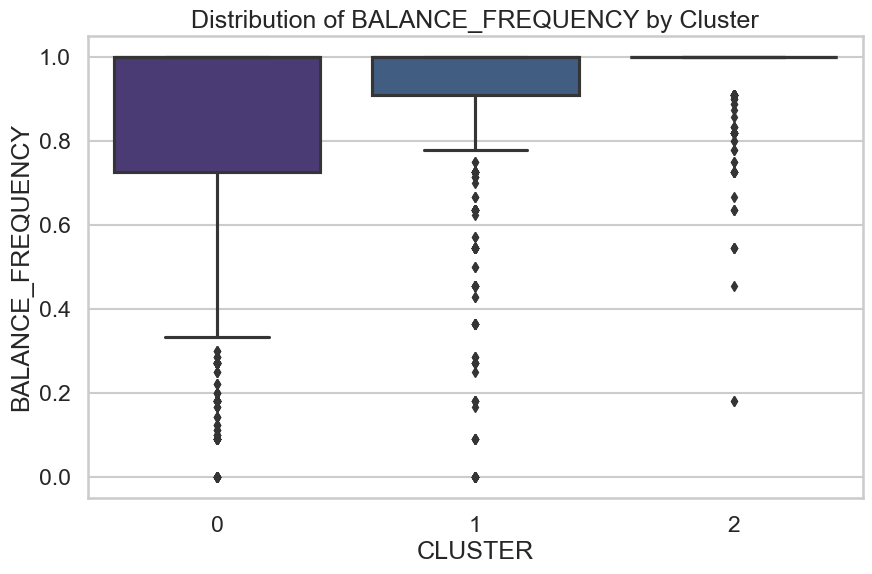

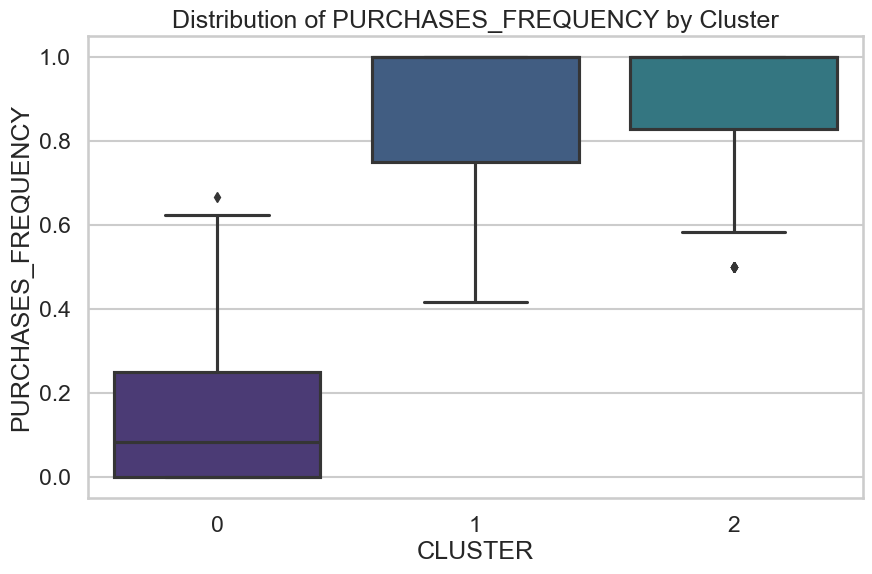

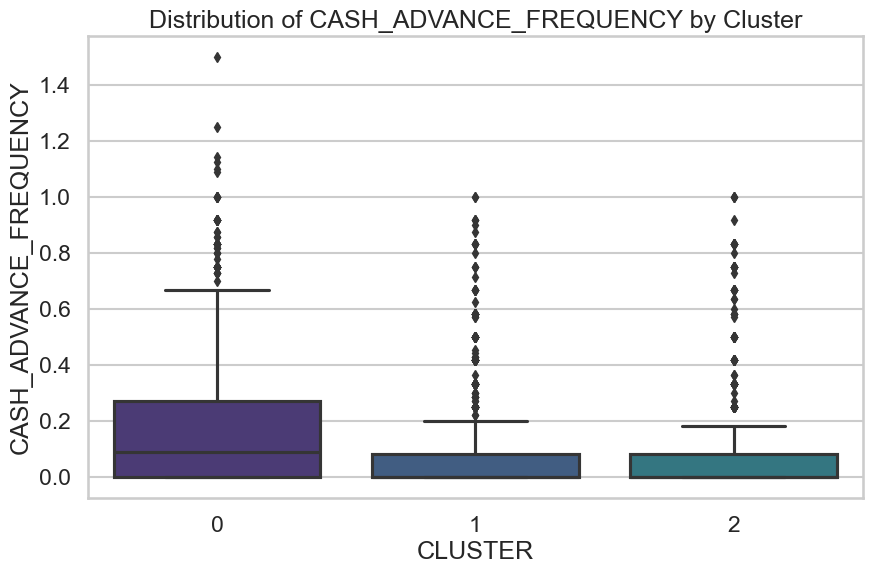

In [43]:
# Plotting frequency of balance, purchases, and cash advance frequency
freq_features = ['BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY', 'CASH_ADVANCE_FREQUENCY']

for feature in freq_features:
    sns.set_palette('viridis')
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='CLUSTER', y=feature, data=df_km)
    plt.title(f'Distribution of {feature} by Cluster')
    plt.show()

Berdasarkan visualisasi menggunakan *boxplot*, menunjukkan informasi yang sesuai pada **Summary Statistic** yang dilakukan diatas.

## **Model Inferece**

Pada tahap ini hanya akan menggunakan 5 random sample dari dataset sebagai **Inference** kinerja model.

### **Picking Random Sample**

In [44]:
# Creating new dataframe without cluster
df_sample = pd.read_csv('credit_customer_information.csv')
df_sample = df_sample.drop(columns=['Unnamed: 0', 'CUST_ID'])
df_sample.tail()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
4470,9629.808851,1.0,0.0,0.0,0.0,4372.393835,0.000000,0.000000,0.0,0.545455,9,0,12000.0,2468.988022,2134.295731,0.0,11
4471,1040.030221,1.0,0.0,0.0,0.0,1390.648290,0.000000,0.000000,0.0,0.545455,18,0,1400.0,290.129620,287.994171,0.0,11
4472,1322.818587,1.0,0.0,0.0,0.0,762.301096,0.000000,0.000000,0.0,0.545455,11,0,1500.0,1035.627320,312.835530,0.0,11
4473,1060.391273,1.0,0.0,0.0,0.0,1475.858013,0.000000,0.000000,0.0,0.545455,10,0,2000.0,407.360560,277.084736,0.0,11
4474,3447.674222,1.0,205.0,205.0,0.0,4548.057776,0.090909,0.090909,0.0,0.545455,7,1,10500.0,665.239171,817.844662,0.0,11


In [45]:
# Picking sample
df_inf = df_sample.sample(n=5)
df_inf = df_inf.reset_index(drop=True)
df_inf

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,1413.006634,1.000000,1678.69,1528.69,150.00,392.356874,0.500000,0.166667,0.333333,0.083333,1,8,1800.0,2308.456562,510.627017,0.083333,12
1,117.063942,0.909091,1035.05,64.90,970.15,0.000000,0.750000,0.083333,0.666667,0.000000,0,10,3000.0,1336.493092,154.164663,0.777778,12
2,39.251217,1.000000,1066.62,339.10,727.52,204.615371,0.833333,0.833333,0.916667,0.083333,1,49,3500.0,1340.881787,102.273663,0.500000,12
3,32.726042,0.636364,303.51,303.51,0.00,0.000000,0.333333,0.333333,0.000000,0.000000,0,5,1200.0,550.181692,100.810197,0.666667,12
4,1256.460026,1.000000,1313.00,1313.00,0.00,0.000000,0.583333,0.583333,0.000000,0.000000,0,29,1200.0,1440.244979,1919.360883,0.000000,12


### **Scaling**

In [46]:
# Scaling data inference
df_inf_scaled = scaler.transform(df_inf)

# Convert into dataframe
df_inf = pd.DataFrame(df_inf_scaled, columns=df_inf.columns)

### **PCA**

In [47]:
# Dimensional reduction
df_inf_pca = pca7.transform(df_inf_scaled)
df_inf_pca = pd.DataFrame(df_inf_pca, columns=['PCA_'+ str(i) for i in range(1,8)])
df_inf_pca.tail(10)

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7
0,-0.020268,0.009375,-0.104757,-0.091394,-0.004852,-0.122865,-0.014217
1,0.479639,-0.205635,0.464483,-0.311919,0.071071,-0.038754,-0.021042
2,0.835222,0.335222,0.173948,-0.055921,-0.008722,-0.013285,-0.057254
3,-0.225258,0.201796,0.636723,-0.099619,-0.104673,-0.077264,-0.070165
4,-0.082790,0.507624,-0.092143,0.070998,-0.068691,-0.239309,-0.027765


### **Predict !**

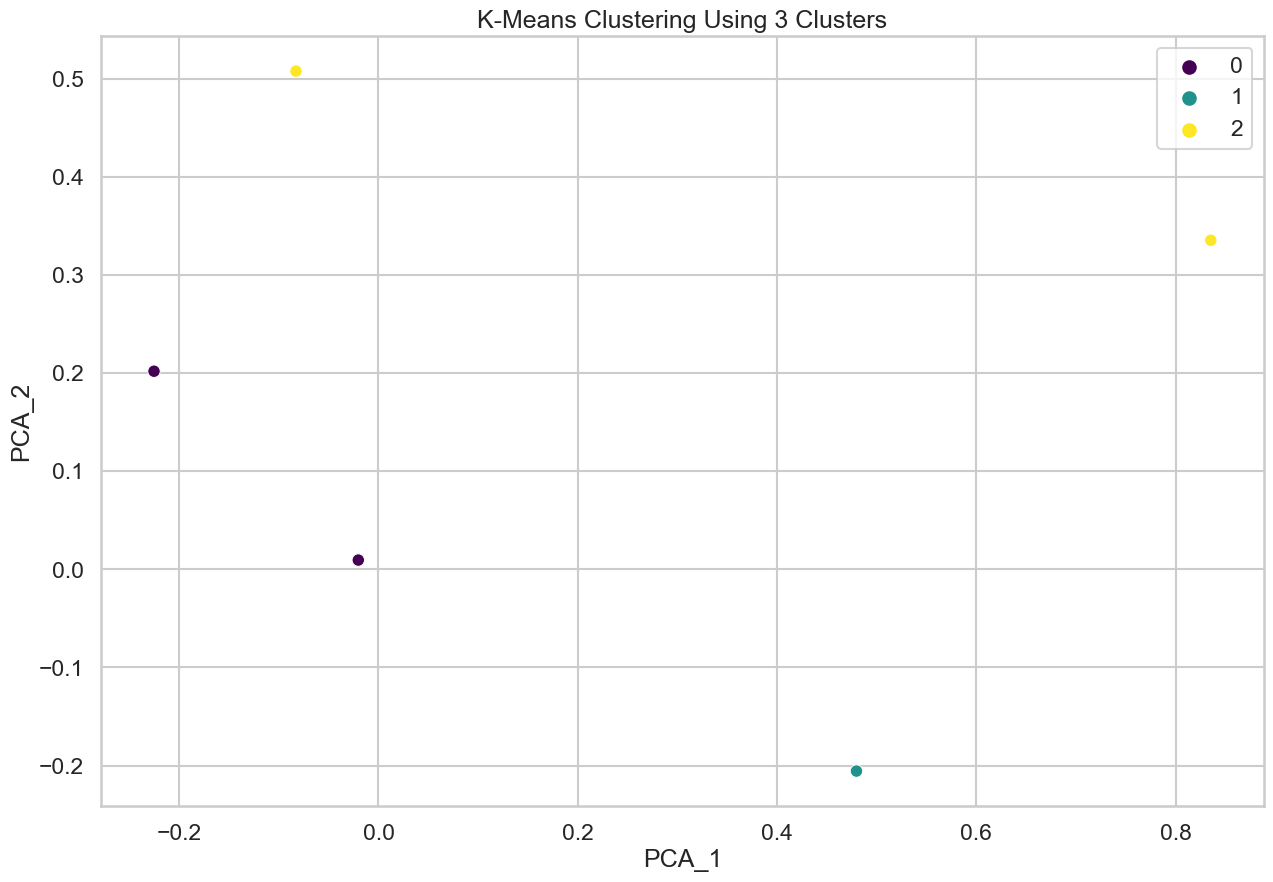

In [48]:
# Prediction
pred = km.predict(df_inf_pca)

plt.figure(figsize=(15, 10))
sns.scatterplot(x='PCA_1', y='PCA_2', hue=pred, data=df_inf_pca, palette='viridis')
plt.title('K-Means Clustering Using 3 Clusters')
plt.show()

Dari 5 data *random sample* yang diambil, dapat dilihat bahwa masing-masing cluster cukup jauh antara satu dengan yang lain yang menandakan model dapat melakukan segmentasi dengan baik.

## **Conclusion**

* **EDA Before Clustering**

Berdasarkan EDA, pengguna kartu kredit lebih banyak yang memiliki *balance* yang sedikit namun mereka sering melakukan *update* terhadap jumlah *balance* yang mereka miliki. Pengguna kartu kredit lebih cenderung melakukan *purchases* dengan harga yang *moderate*. Selain itu, mereka jarang menggunakan *cash advance*, kalaupun ada yang menggunakan *cash advance* itu hanya dengan jumlah yang relatif kecil. Ini mungkin dikarenakan terdapat *limit* pada penggunaan *cash advance*.

* **Business Implication For Each Cluster**
    - **Cluster 0,**
        Memfokuskan pada penawaran produk bernilai tinggi yang disesuaikan, melakukan promosi *cash advance* yang ditargetkan, serta layanan konsultasi keuangan pribadi, sambil memantau *credit risk*.
    - **Cluster 1,**
        Mengembangkan program *daily rewards*, mempromosikan *rewards* transaksi rutin, dan mempertimbangkan opsi pembiayaan dengan bunga yang rendah, dengan fokus pada retensi dan peningkatan.
    - **Cluster 2,**
        Menawarkan atau menyediakan produk premium, penawaran khusus untuk pengeluaran yang tergolong *luxury*, layanan *cash advance* yang lebih baik, dan program loyalitas dinamis, sambil memantau pola pengeluaran dengan cermat.

* **Model Analysis**

`K-Means` digunakan disini dikarenakan dataset semua merupakan numerikal. Untuk *cluster* yang dipilih sendiri itu adalah 3 *cluster*. Jumlah ini diambil berdasarkan evaluasi dari **Silhoutte Score**.
